# Transformations and diagnostics

Fall 2022: Peter Ralph

https://uodsci.github.io/dsci345

In [1]:
import matplotlib
import matplotlib.pyplot as plt
matplotlib.rcParams['figure.figsize'] = (15, 8)
import numpy as np
import pandas as pd
from dsci345 import pretty

rng = np.random.default_rng()

$$\renewcommand{\P}{\mathbb{P}} \newcommand{\E}{\mathbb{E}} \newcommand{\var}{\text{var}} \newcommand{\sd}{\text{sd}} \newcommand{\cov}{\text{cov}} \newcommand{\cor}{\text{cor}}$$
This is here so we can use `\P` and `\E` and `\var` and `\cov` and `\cor` and `\sd` in LaTeX below.

# An example

Let's look at how newborn (i.e., "neonate") body mass
is related to adult body mass,
across a bunch of mammal species
(in the order Carnivora, including dogs, cats, bears, weasels, and seals).

In [2]:
carnivores = pd.read_csv("data/carnivora_sizes.csv").set_index("Binomial")

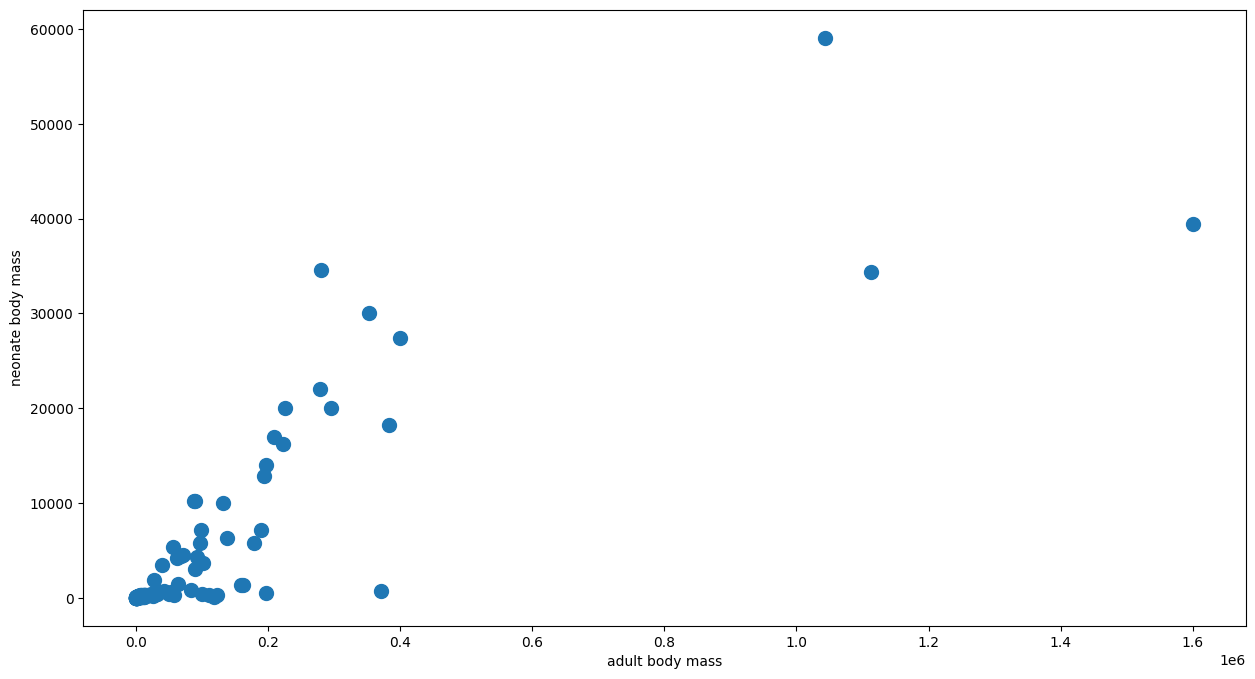

In [3]:
plt.scatter(carnivores.AdultBodyMass_g, carnivores.NeonateBodyMass_g, s=100);
plt.xlabel("adult body mass"); plt.ylabel("neonate body mass");

But - there's some "substructure"!

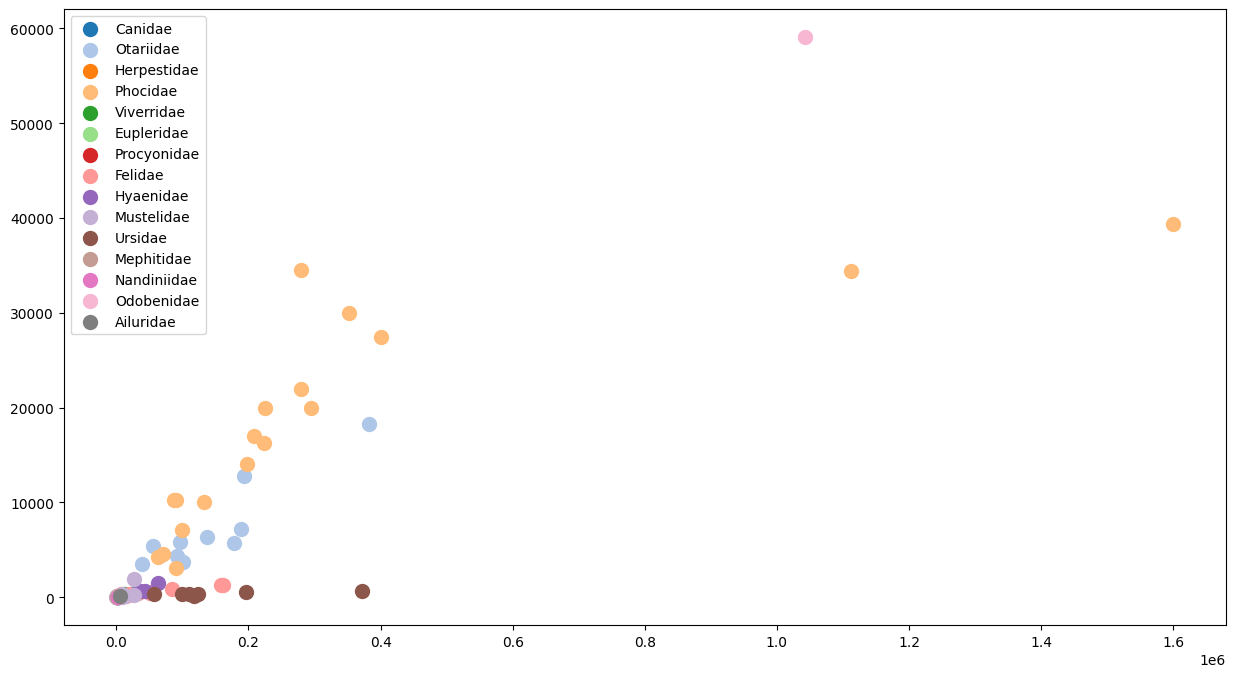

In [4]:
colors = {f: c for f, c in zip(carnivores.Family.unique(), plt.cm.tab20.colors)}
for f in colors:
    sub = carnivores[carnivores.Family == f]
    plt.scatter(sub.AdultBodyMass_g, sub.NeonateBodyMass_g, color=colors[f], s=100, label=f)
plt.legend();

# First pass: a normal linear model

Let's fit a linear model and see what it's predictions are like:

In [5]:
from sklearn.linear_model import LinearRegression as lm
fit1 = lm().fit(carnivores[['AdultBodyMass_g']], carnivores.NeonateBodyMass_g)

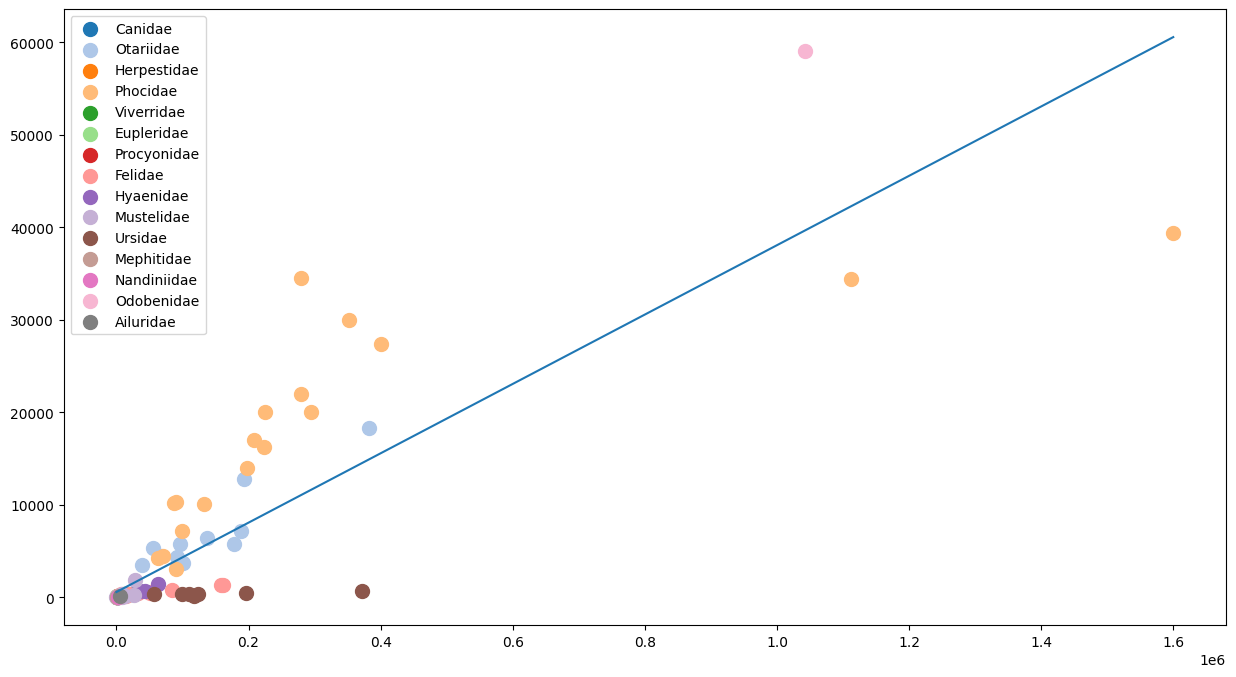

In [6]:
for f in colors:
    sub = carnivores[carnivores.Family == f]
    plt.scatter(sub.AdultBodyMass_g, sub.NeonateBodyMass_g, color=colors[f], s=100, label=f)
pred = pd.DataFrame({
    "AdultBodyMass_g": np.linspace(0, 1.6e6, 21)
})
pred['NeonateBodyMass_g'] = fit1.predict(pred)
plt.plot(pred.AdultBodyMass_g, pred.NeonateBodyMass_g)
plt.legend();

# Heteroskedasticity?

# Diagnostics

Two good generic diagnostic plots are:

1. residuals versus fitted
2. distribution of residuals (histogram or QQ plot)

*What's the idea?*

1. If the residuals show predictable patterns, we could improve our model,
2. and if the residual SD differs systematically,
    we have *heteroskedasticity*
    (and so our model isn't using all the data very well).

## Patterns in the residuals

Here's data that are nonlinear but we don't know it:

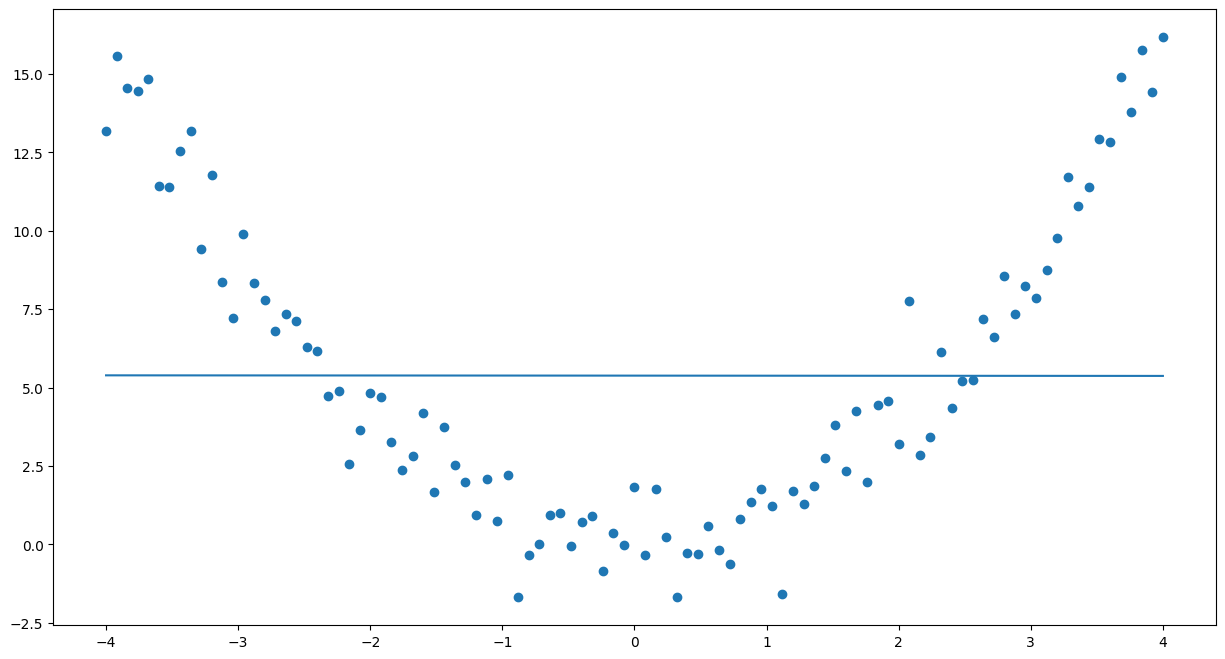

In [7]:
X = np.array([np.linspace(-4, 4, 101)]).T
y = rng.normal(loc=X**2, scale=1)
xy_lm = lm().fit(X, y)
yhat = xy_lm.predict(X)
plt.scatter(X[:,0], y)
plt.plot(X[:,0], yhat);

And, this shows up in the fit-versus-residuals plot:

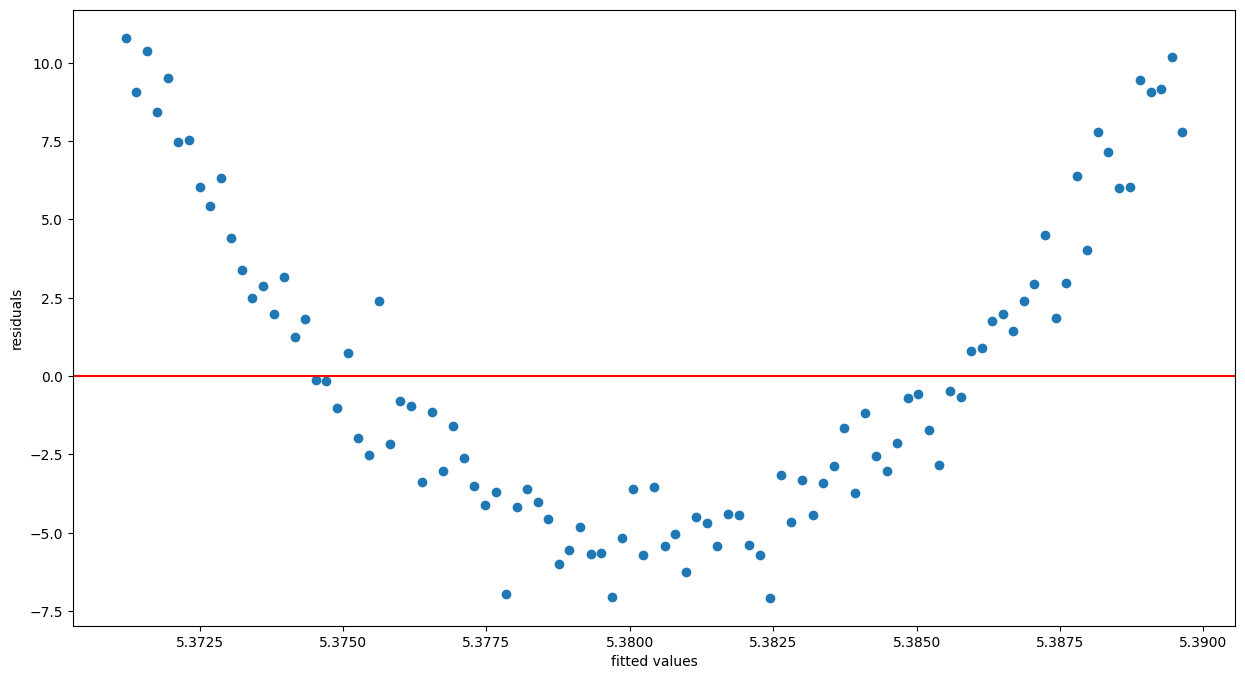

In [8]:
resids = y - yhat
plt.scatter(yhat, resids);
plt.axhline(0, color='red')
plt.xlabel("fitted values"); plt.ylabel("residuals");

Solution: add a quadratic term!

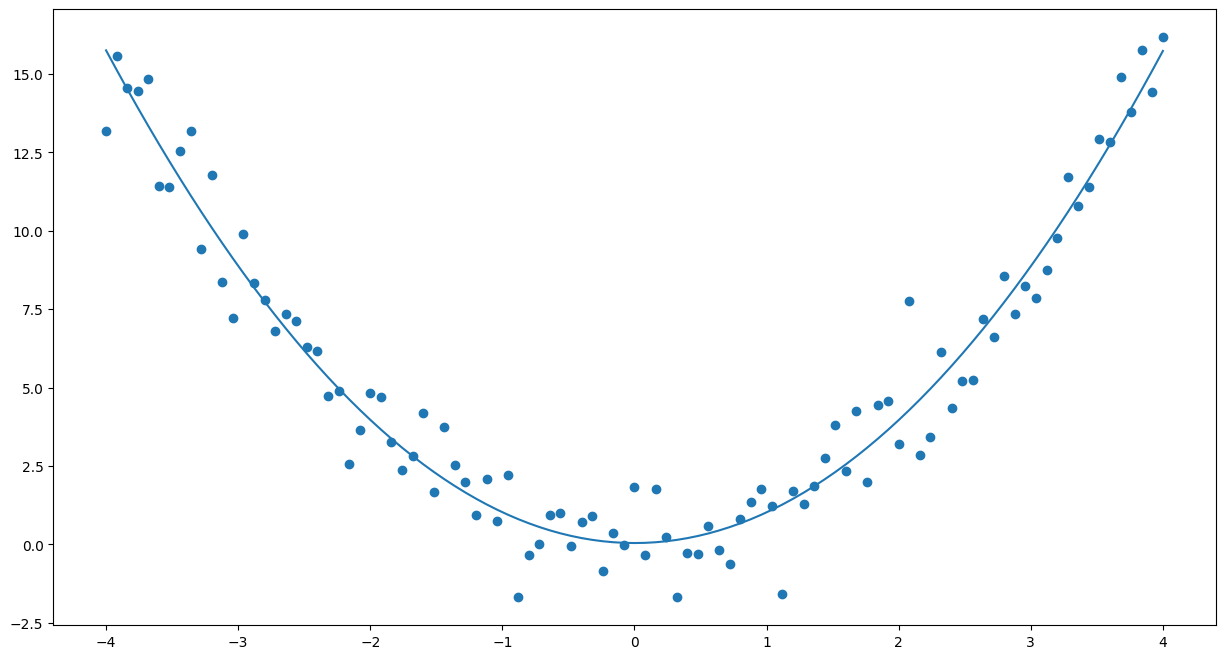

In [9]:
XX2 = np.hstack([X, X**2])
xy_lm = lm().fit(XX2, y)
yhat = xy_lm.predict(XX2)
plt.scatter(X[:,0], y)
plt.plot(X[:,0], yhat);

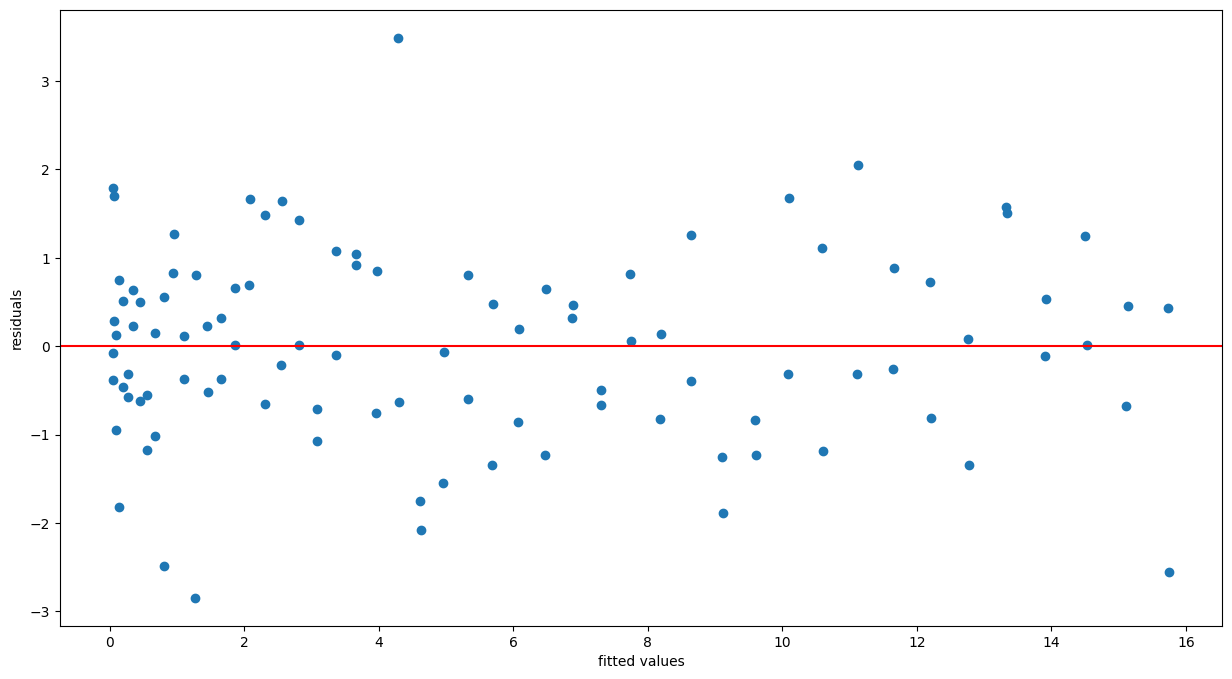

In [10]:
resids = y - yhat
plt.scatter(yhat, resids);
plt.axhline(0, color='red')
plt.xlabel("fitted values"); plt.ylabel("residuals");

# Back to our data

Let's look at this in our data:

In [11]:
carnivores['PredictedNeonateMass'] = fit1.predict(
    carnivores[['AdultBodyMass_g']]
)
carnivores['residual'] = carnivores['NeonateBodyMass_g'] - carnivores['PredictedNeonateMass']

No particular pattern (?), but certainly: heteroskedasticity!

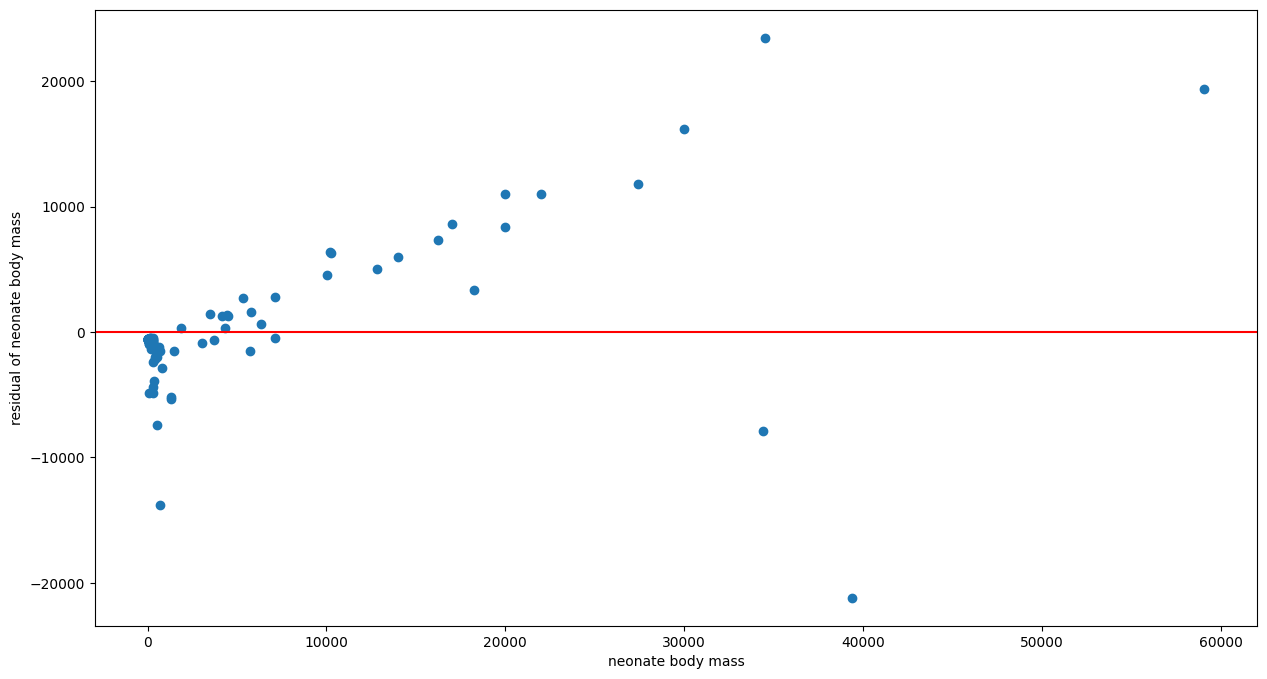

In [12]:
plt.scatter(carnivores.NeonateBodyMass_g, carnivores.residual)
plt.axhline(0, color='red');
plt.xlabel("neonate body mass"); plt.ylabel("residual of neonate body mass");

Why is heteroskedasticity a problem?
Above, we see that small body masses are all very close to the predicted line.
Indeed they have to be! A 5g weasel can't have a 100kg baby.
So: these small animals are not affecting the fit of that line very much at all.
Maybe that's okay - if we're interested in a relationship that holds
only for big animals, for instance -
but we should dig more.

# A transformation

One reason for having bad model fit
is that you aren't looking at the data through the right lens.

Most commonly:
if the data vary by *percent changes*,
then using standard methods (that assume *additive changes*)
won't do so great.
But, the **logarithm** turns percent changes
into additive changes!

Let's try it out.

Here's the data with log-log axes:

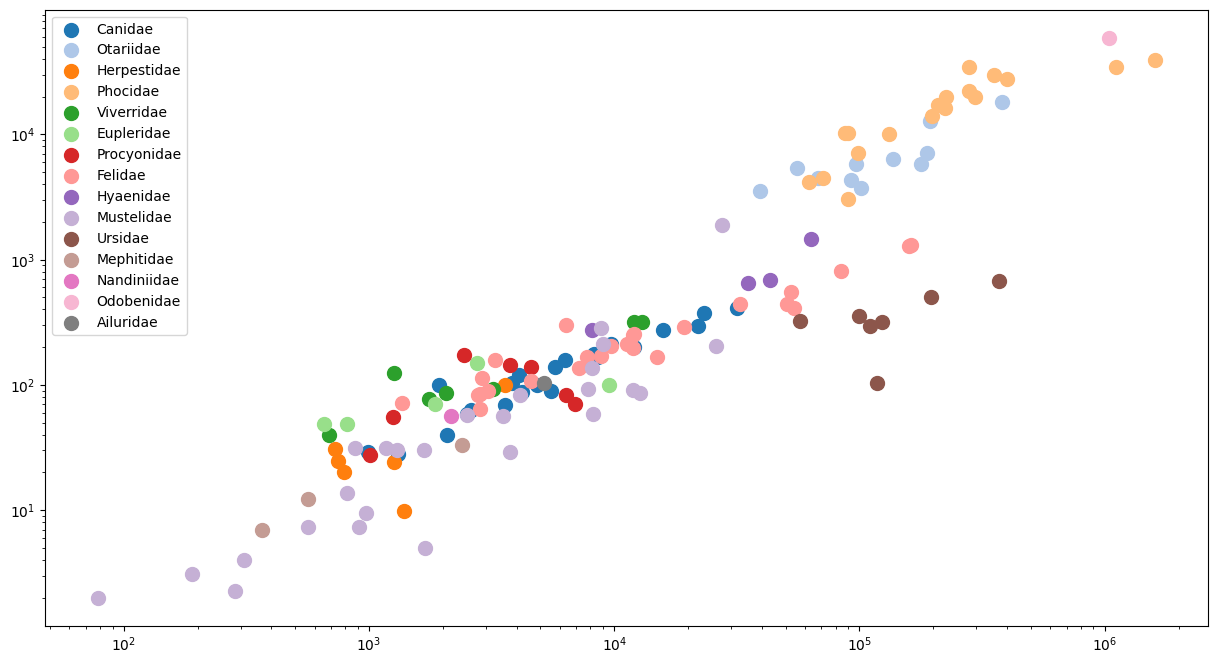

In [13]:
for f in colors:
    sub = carnivores[carnivores.Family == f]
    plt.scatter(sub.AdultBodyMass_g, sub.NeonateBodyMass_g, color=colors[f], s=100, label=f)
plt.xscale("log"); plt.yscale("log")
plt.legend();

Okay, let's now fit a model
to log(adult) and log(neonate) mass:

/usr/lib/python3/dist-packages/pandas/core/arraylike.py:364: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


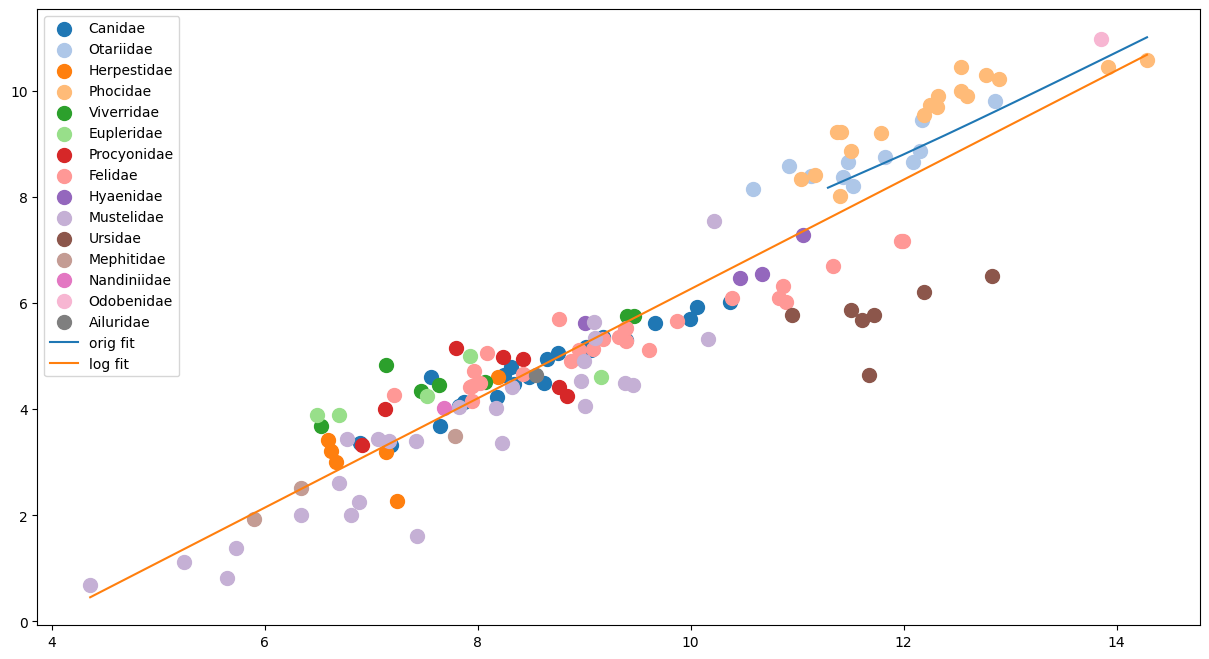

In [15]:
carnivores['logAdultBodyMass_g'] = np.log(carnivores['AdultBodyMass_g'])
carnivores['logNeonateBodyMass_g'] = np.log(carnivores['NeonateBodyMass_g'])
fit2 = lm().fit(carnivores[['logAdultBodyMass_g']], carnivores.logNeonateBodyMass_g)
for f in colors:
    sub = carnivores[carnivores.Family == f]
    plt.scatter(sub.logAdultBodyMass_g, sub.logNeonateBodyMass_g, color=colors[f], s=100, label=f)
pred2 = pd.DataFrame({
    "logAdultBodyMass_g": np.linspace(np.min(carnivores.logAdultBodyMass_g),
                                      np.max(carnivores.logAdultBodyMass_g), 201)
})
pred2['logNeonateBodyMass_g'] = fit2.predict(pred2)
plt.plot(np.log(pred.AdultBodyMass_g), np.log(pred.NeonateBodyMass_g), label='orig fit')
plt.plot(pred2.logAdultBodyMass_g, pred2.logNeonateBodyMass_g, label='log fit')
plt.legend();

## Conclusions?

1. taking logs is definitely the way to fit these data
2. each family looks to have a different relationship
3. so a better model would allow different lines for each family

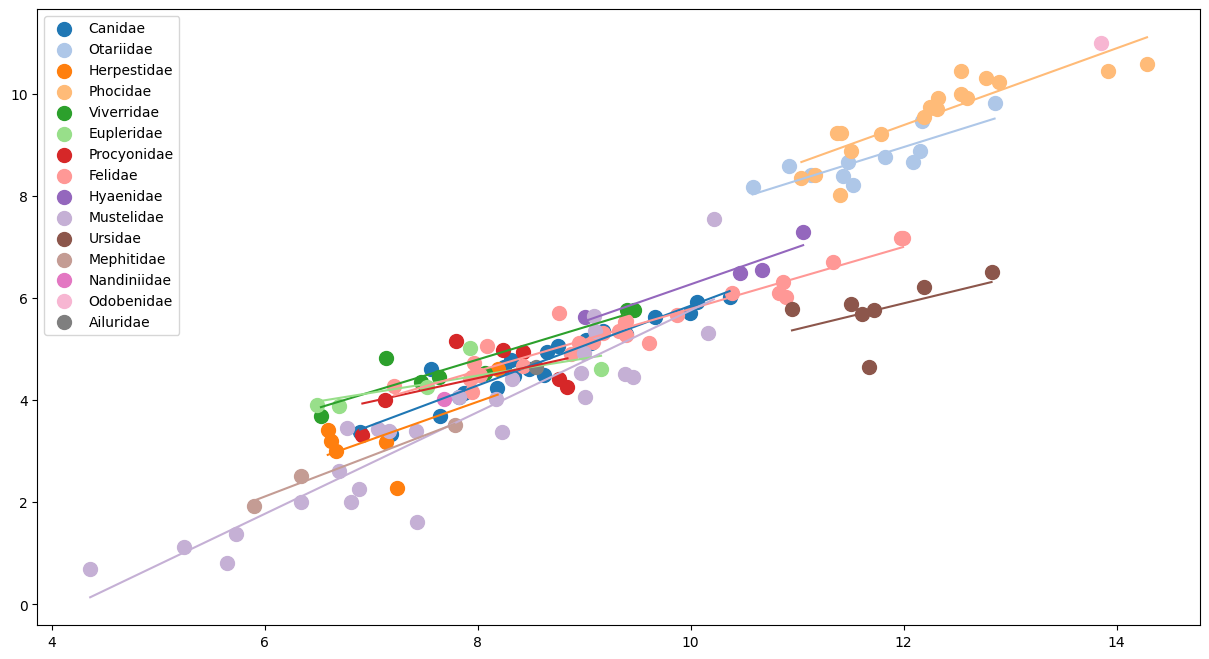

In [17]:
for f in colors:
    sub = carnivores[carnivores.Family == f]
    fit_sub = lm().fit(sub[['logAdultBodyMass_g']], sub.logNeonateBodyMass_g)
    plt.scatter(sub.logAdultBodyMass_g, sub.logNeonateBodyMass_g, color=colors[f], s=100, label=f)
    pred_sub = pd.DataFrame({
        "logAdultBodyMass_g": np.linspace(np.min(sub.logAdultBodyMass_g),
                                          np.max(sub.logAdultBodyMass_g), 201)
    })
    pred_sub['logNeonateBodyMass_g'] = fit_sub.predict(pred_sub)
    plt.plot(pred_sub.logAdultBodyMass_g, pred_sub.logNeonateBodyMass_g, color=colors[f])
plt.legend();